In [1]:
import pandas as pd
import os
import json
import sys
from os.path import expanduser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pysd2cat.data import pipeline
from pysd2cat.analysis import correctness 

from data_converge.util import data_utils as du
from agavepy.agave import Agave, AgaveError

ag = Agave.restore()

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


DATA_CONVERGE_PROJECT="sd2e-project-43"

data_converge_base = os.path.join(expanduser("~"), 'sd2e-projects', DATA_CONVERGE_PROJECT)
experiment_dir = os.path.realpath(os.path.join(data_converge_base, 'test'))
experiment_dir_contents = [os.path.realpath(os.path.join(experiment_dir, x)) for x in os.listdir(experiment_dir)]

experiments = [x for x in  experiment_dir_contents 
               if os.path.isdir(x) and "dc_" in x]

DATA_CONVERGE_CORRECTNESS_DATA_PROJECT="sd2e-project-45"
DATA_CONVERGE_CORRECTNESS_DATA_PROJECT_ID="data-sd2e-projects.sd2e-project-45"


data_converge_correctness_data_base = os.path.join(expanduser("~"), 'sd2e-projects', DATA_CONVERGE_CORRECTNESS_DATA_PROJECT)

correctness_dir = os.path.join(data_converge_correctness_data_base, 'correctness')
correctness_dir_contents = [os.path.realpath(os.path.join(correctness_dir, x)) for x in os.listdir(correctness_dir)]
data_dir = os.path.join(data_converge_correctness_data_base, 'data')

experiments.sort()
experiments


/work/05202/dbryce/jupyter_packages/lib/python3.6/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


['/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_CEN-PK-Inducible-CRISPR-Characterization_20200426200027',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response_20200414091814',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response_20200423200308',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Growth-Curves_20200327174254',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Growth-Curves_20200414150010',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Growth-Curves_20200423201016',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Dose-Response_20200327165322',
 '/work/projects/SD2E-Commu

In [12]:
approved_experiments = [
    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response_20200423200308',
    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Dose-Response_20200423194728',
    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200423193808',    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200423195648',
    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200423194115',
 '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-Doxycycline-OR-Gate-Plant-TF-Dose-Response_20200423201302',

    '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-OR-Gate-CRISPR-Dose-Response_20200423202039'
]

In [10]:
def get_log_gfp(df):
    df['log BL1-A'] = df['BL1-A'].apply(lambda x: x+1.0).apply(np.log10)
    return df.replace([np.inf, -np.inf], np.nan).dropna()

def get_predictions(experiment_path):
    experiment_file = experiment_path.split('/')[-1]+".csv"
    experiment="_".join(experiment_file.split('.')[0].split('_')[:-1])
    df = pd.read_csv(os.path.join(data_dir, experiment_file))
    ddf = get_log_gfp(df)
    return ddf
    

def plot_controls(ddf, experiment):
    controls = [x for x in ddf.strain_name.unique() if 'control' in x.lower()]
    for control in controls:
        my_data = ddf.loc[ddf.strain_name == control]['log BL1-A'].sample(n=5000, random_state=1)
        sns.distplot(my_data, label=control, hist=False) 
    plt.title(experiment.split('/')[-1])
    plt.xlabel("ln BL1-A")
    plt.legend(bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')       


def compute_fold_change(ddf):
    """
    Compute maximum separation of low and high values along inducer and time dimensions.
    Compute difference in terms of all events, and culling minority predicted events.
    
    Ouput is the format: strain, replicate, timepoint, inducer_concentration, diff_all, diff_pred
    If the separation is wrt. inducer, then rows will use NaN for inducer_concentration, and similarly
    for the timepoint dimension.    
    """
    result = ddf[['strain_name', 'replicate']].drop_duplicates().reset_index(drop=True)
    
    ## Group data
    sample_groups = ddf.groupby(['strain_name', 'inducer_concentration', 'replicate', 'timepoint'])
    
    ## Get mean log GFP
    mean_log_gfp = sample_groups.agg(np.mean)['log BL1-A'].reset_index()
    
    ## Get max difference wrt. time
    max_mean_log_gfp_time = mean_log_gfp.groupby(['strain_name', 'inducer_concentration', 'replicate'])['log BL1-A'].agg(np.ptp).reset_index().rename(columns={"log BL1-A" : "diff_all"})
    result = result.merge(max_mean_log_gfp_time, on=['strain_name', 'replicate'], how='outer')
    
    ## Get max difference wrt. inducer
    max_mean_log_gfp_inducer = mean_log_gfp.groupby(['strain_name', 'timepoint', 'replicate'])['log BL1-A'].agg(np.ptp).reset_index().rename(columns={"log BL1-A" : "diff_all"})
    result = result.append(max_mean_log_gfp_inducer, sort=True)
    
    result_pred = ddf[['strain_name', 'replicate']].drop_duplicates().reset_index(drop=True)
    ## Drop minority classes 
    sample_groups = ddf.groupby(['strain_name', 'inducer_concentration', 'replicate', 'timepoint', 'predicted_output'])
    group_len = sample_groups.agg(len)['log BL1-A'].reset_index().rename(columns={"log BL1-A" : "count"}).reset_index(drop=True)
    group_mean = sample_groups.agg(np.mean)['log BL1-A'].reset_index().reset_index(drop=True)
    group_mean = group_mean.merge(group_len)
    major_agg = group_mean.sort_values('count', ascending=False).drop_duplicates(['strain_name', 'inducer_concentration', 'replicate', 'timepoint']).sort_values(['strain_name', 'replicate', 'inducer_concentration'])

    #return major_agg
    ## Get max difference wrt. time
    max_major_mean_log_gfp_time = major_agg.groupby(['strain_name', 'inducer_concentration', 'replicate'])['log BL1-A'].agg(np.ptp).reset_index().rename(columns={'log BL1-A' : "diff_pred"})
    result_pred = result_pred.merge(max_major_mean_log_gfp_time, on=['strain_name', 'replicate'], how='outer')


    ## Get max difference wrt. inducer
    max_major_mean_log_gfp_inducer = major_agg.groupby(['strain_name', 'timepoint', 'replicate'])['log BL1-A'].agg(np.ptp).reset_index().rename(columns={'log BL1-A' : "diff_pred"})
    result_pred = result_pred.append(max_major_mean_log_gfp_inducer, sort=True)

    
    result = result.merge(result_pred, on=['strain_name', 'replicate', 'timepoint', 'inducer_concentration'])
    result = result.sort_values(by=['strain_name', 'replicate'])
    
    return result
    

In [13]:
for experiment in approved_experiments:
    experiment_name = experiment.split("/")[-1]
    data_file = experiment_name + ".csv"

    data_files = [x['name'] for x in ag.files.list(filePath="10x", systemId=DATA_CONVERGE_CORRECTNESS_DATA_PROJECT_ID)]
    if not data_file in data_files:
        ddf = get_predictions(experiment)
        if ddf is None:
            print(data_file, "data not present")
            continue
            
        tdf = compute_fold_change(ddf)
        tdf.sort_values(by=['diff_pred'], ascending=False)
        if tdf is not None:
            tdf.to_csv(data_file)
            ag.files.importData(filePath="10x", 
                        fileToUpload=open(data_file, 'rb'),
                        fileName=data_file,
                        systemId=DATA_CONVERGE_CORRECTNESS_DATA_PROJECT_ID)
        else:
            print(data_file, "problem in analysis")



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


KeyError: 'strain_name'

/work/projects/SD2E-Community/prod/projects/sd2e-project-43/test/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200414085017


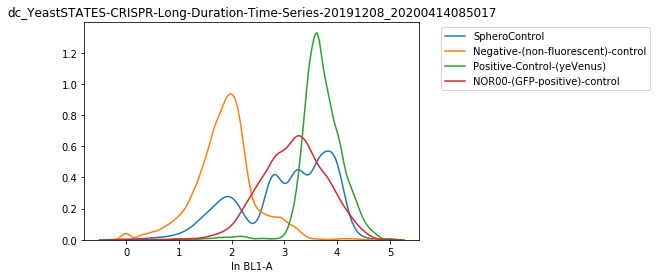

In [78]:
experiment = approved_experiments[2]
print(experiment)
ddf = get_predictions(experiment)
plot_controls(ddf, experiment)

In [ ]:
ddf.columns

In [79]:
strains = ddf.strain_name.unique()
strains.sort()
print(strains)

timepoints = ddf.timepoint.unique()
timepoints.sort()
print(timepoints)

inducer_concentrations = ddf.inducer_concentration.unique()
inducer_concentrations.sort()
print(inducer_concentrations)


['BE-inducible-fluorescent-protein' 'Inducible-CRISPR-Gate-1'
 'Inducible-CRISPR-Gate-2' 'Inducible-CRISPR-Gate-3'
 'Inducible-CRISPR-Gate-4' 'Inducible-CRISPR-Gate-5'
 'Inducible-CRISPR-Gate-6' 'Inducible-CRISPR-Gate-7'
 'NOR00-(GFP-positive)-control' 'Negative-(non-fluorescent)-control'
 'Positive-Control-(yeVenus)' 'SpheroControl' 'beads_spherotech_pps_6K']
[52.]
[0.0e+00 4.0e-06 1.0e-05 2.5e-05 4.0e-05 6.0e-05 8.0e-05 1.0e-04 2.0e-04
 4.0e-04]


In [81]:
tdf = compute_fold_change(ddf)
tdf.sort_values(by=['diff_pred'], ascending=False)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,diff_all,inducer_concentration,replicate,strain_name,timepoint,diff_pred
286,1.494076,NaN,2,Inducible-CRISPR-Gate-4,52.0,1.628468
295,1.235653,NaN,2,Inducible-CRISPR-Gate-7,52.0,1.413017
296,1.146376,NaN,3,Inducible-CRISPR-Gate-7,52.0,1.341998
292,1.191600,NaN,2,Inducible-CRISPR-Gate-6,52.0,1.334053
288,1.067634,NaN,1,Inducible-CRISPR-Gate-5,52.0,1.273375
291,1.029585,NaN,1,Inducible-CRISPR-Gate-6,52.0,1.244915
289,0.957395,NaN,2,Inducible-CRISPR-Gate-5,52.0,1.208977
276,0.648247,NaN,1,Inducible-CRISPR-Gate-1,52.0,1.188423
279,0.826845,NaN,1,Inducible-CRISPR-Gate-2,52.0,1.110043
290,0.893100,NaN,3,Inducible-CRISPR-Gate-5,52.0,1.095894


Strain:  CRISPR_CEN.PK2_24952 Replicate:  1


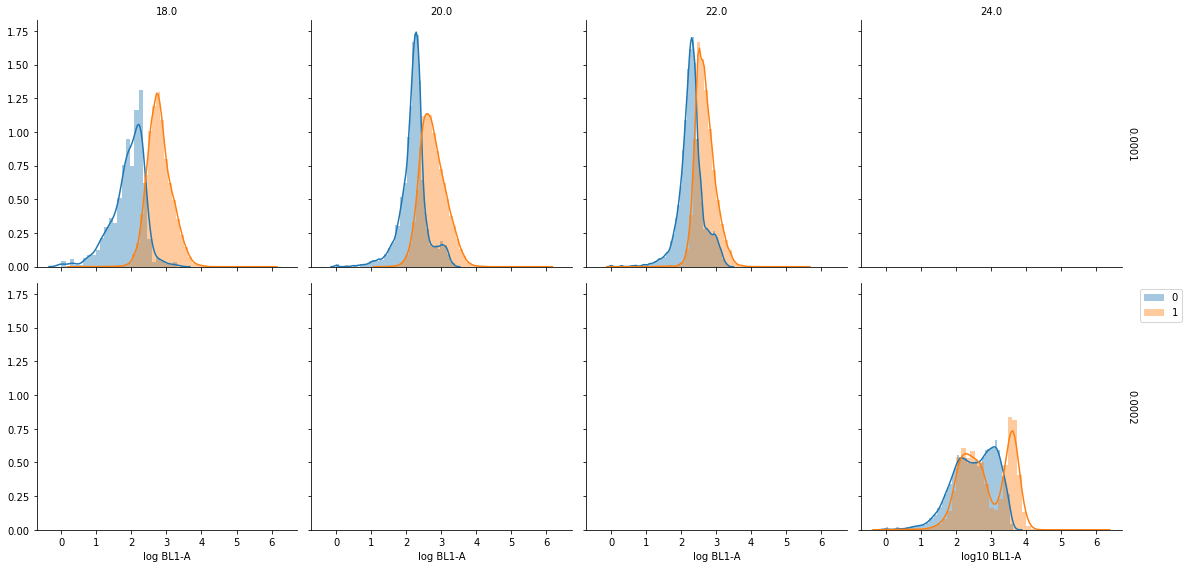

Strain:  CRISPR_CEN.PK2_24952 Replicate:  2


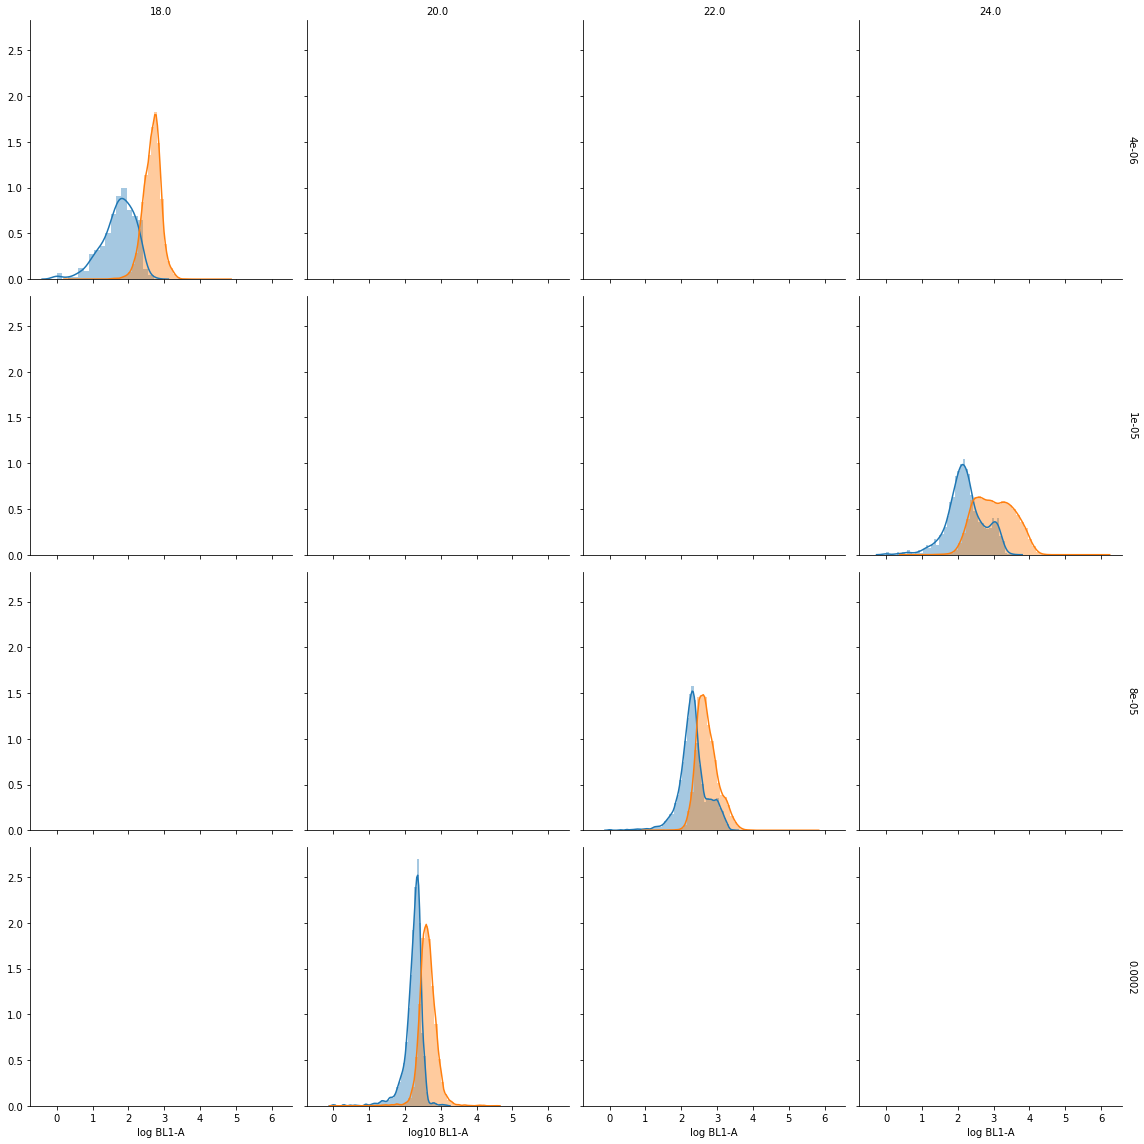

Strain:  CRISPR_CEN.PK2_24952 Replicate:  3


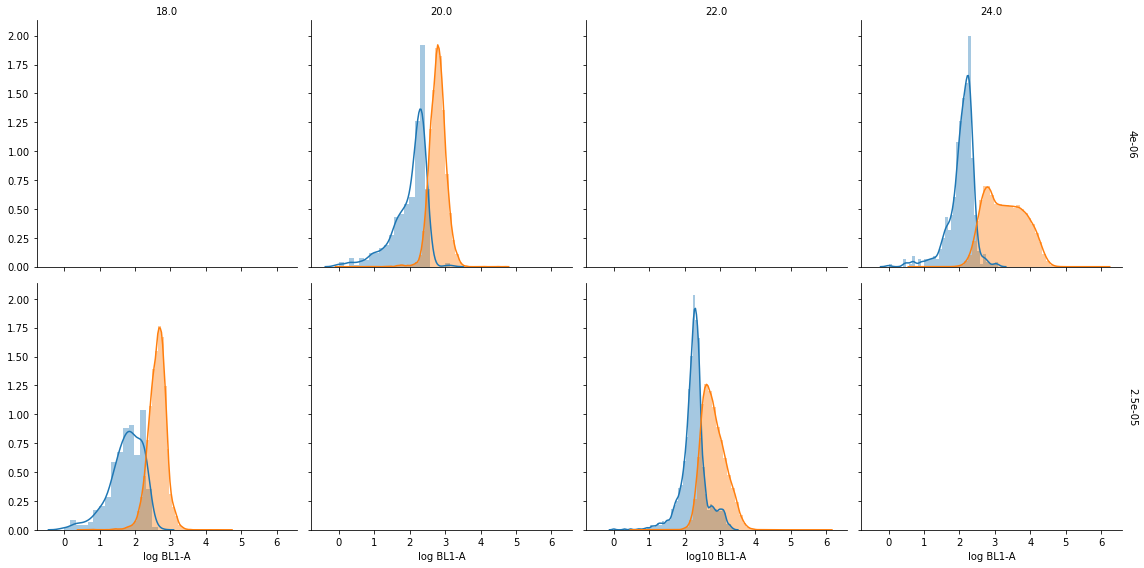

Strain:  CRISPR_CEN.PK2_24952 Replicate:  4


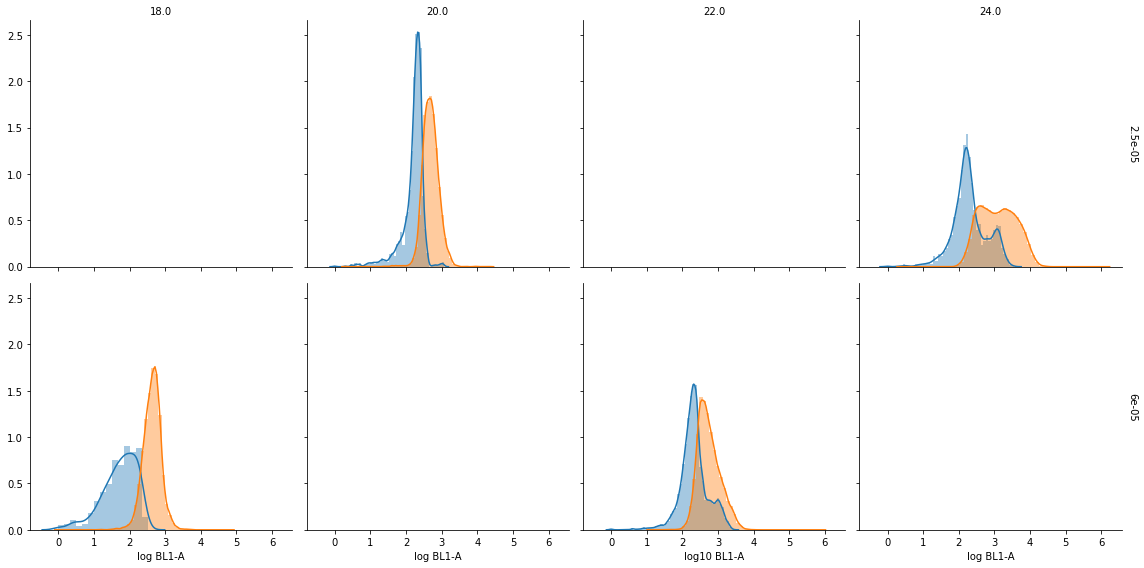

Strain:  CRISPR_CEN.PK2_24952 Replicate:  5


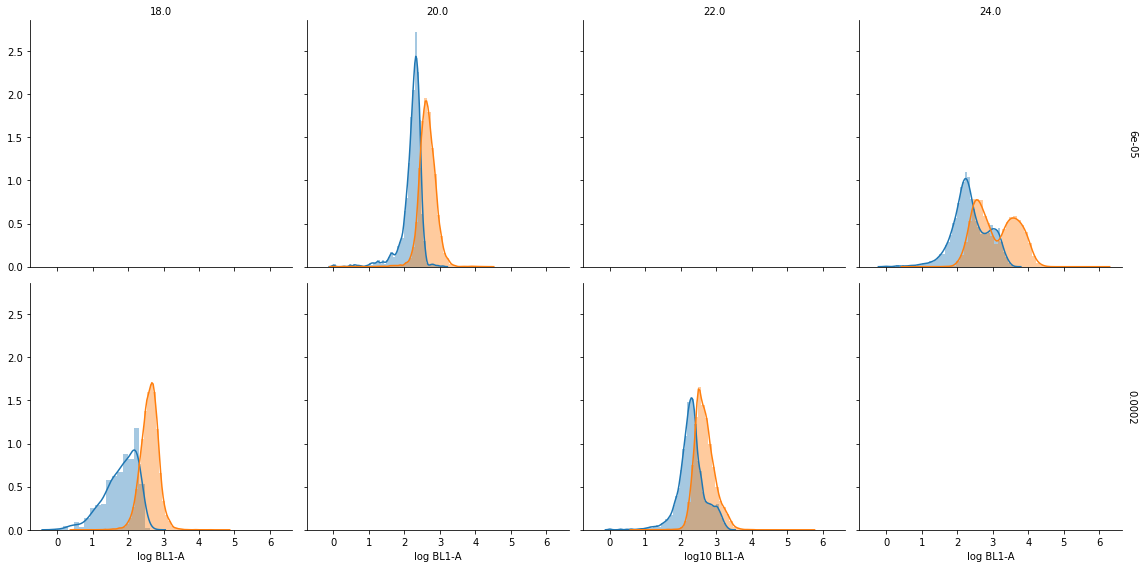

Strain:  CRISPR_CEN.PK2_24952 Replicate:  6


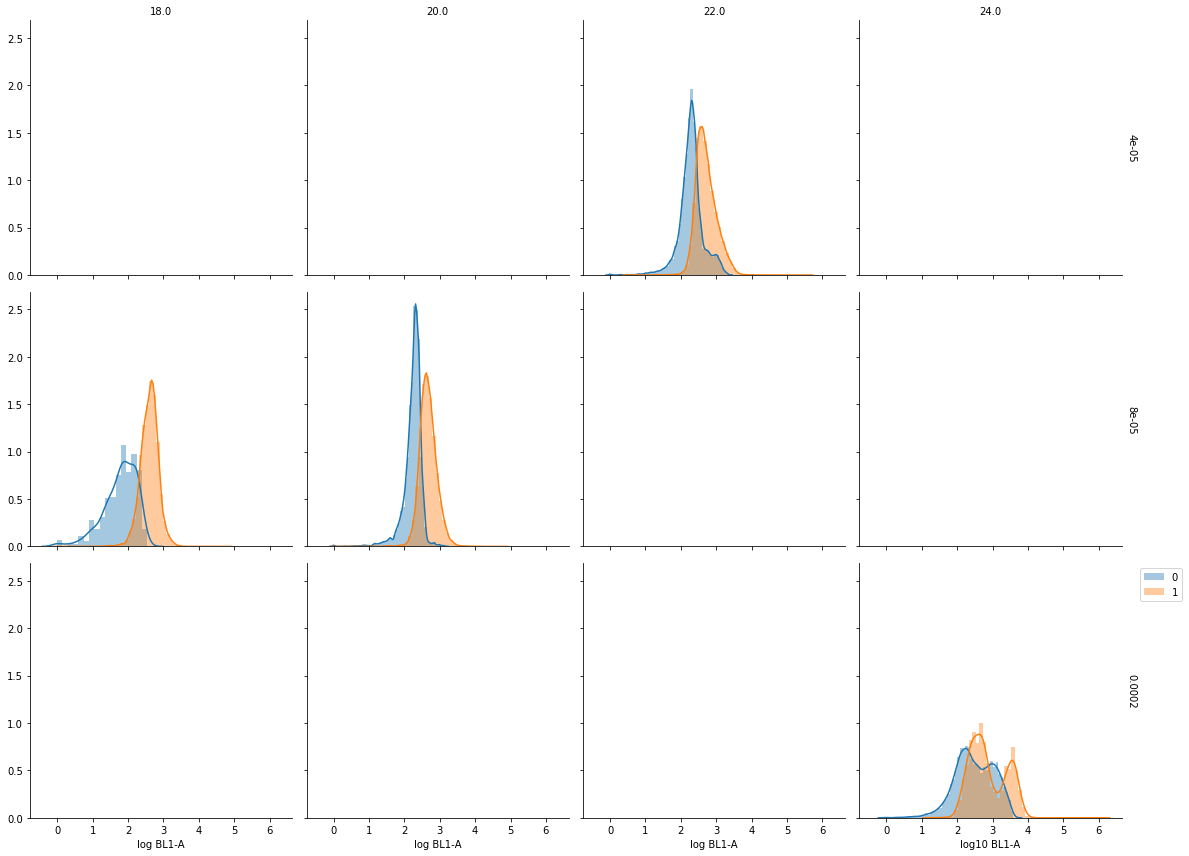

Strain:  CRISPR_CEN.PK2_24952 Replicate:  7


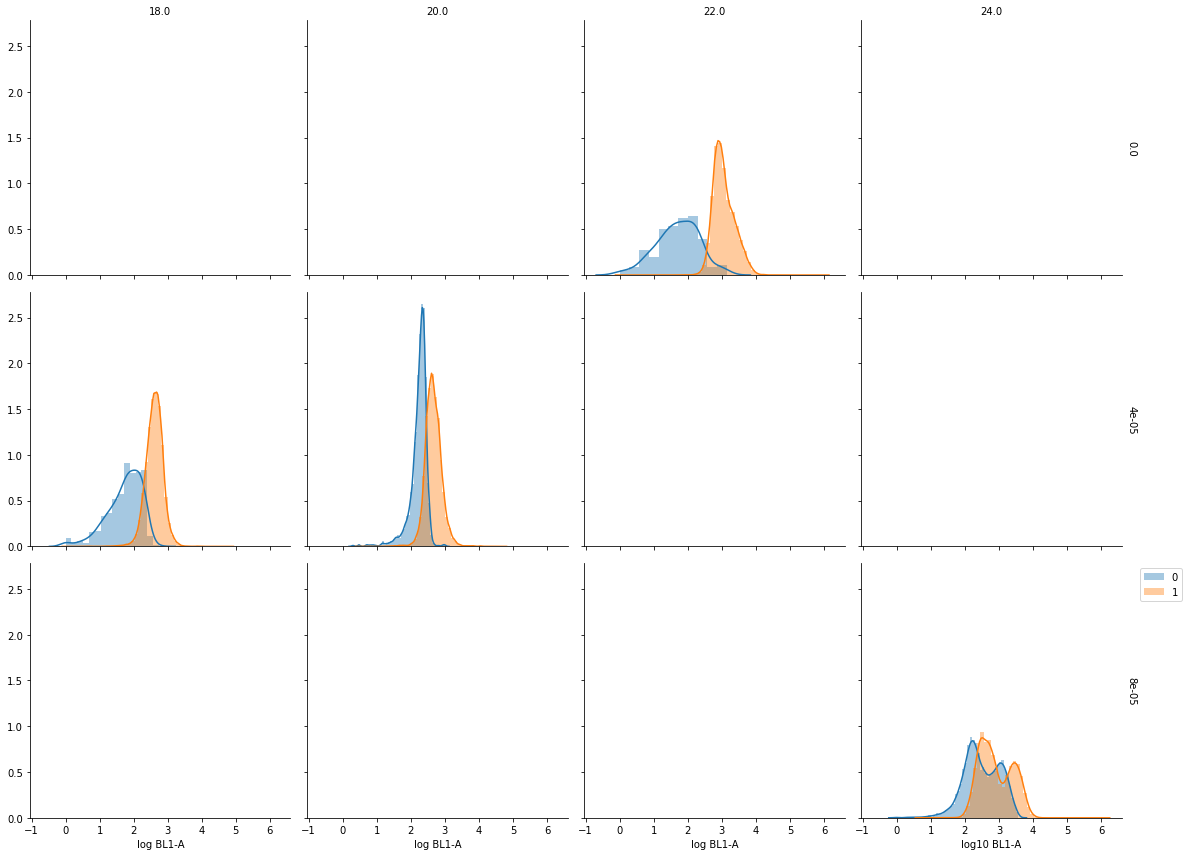

Strain:  CRISPR_CEN.PK2_24952 Replicate:  8


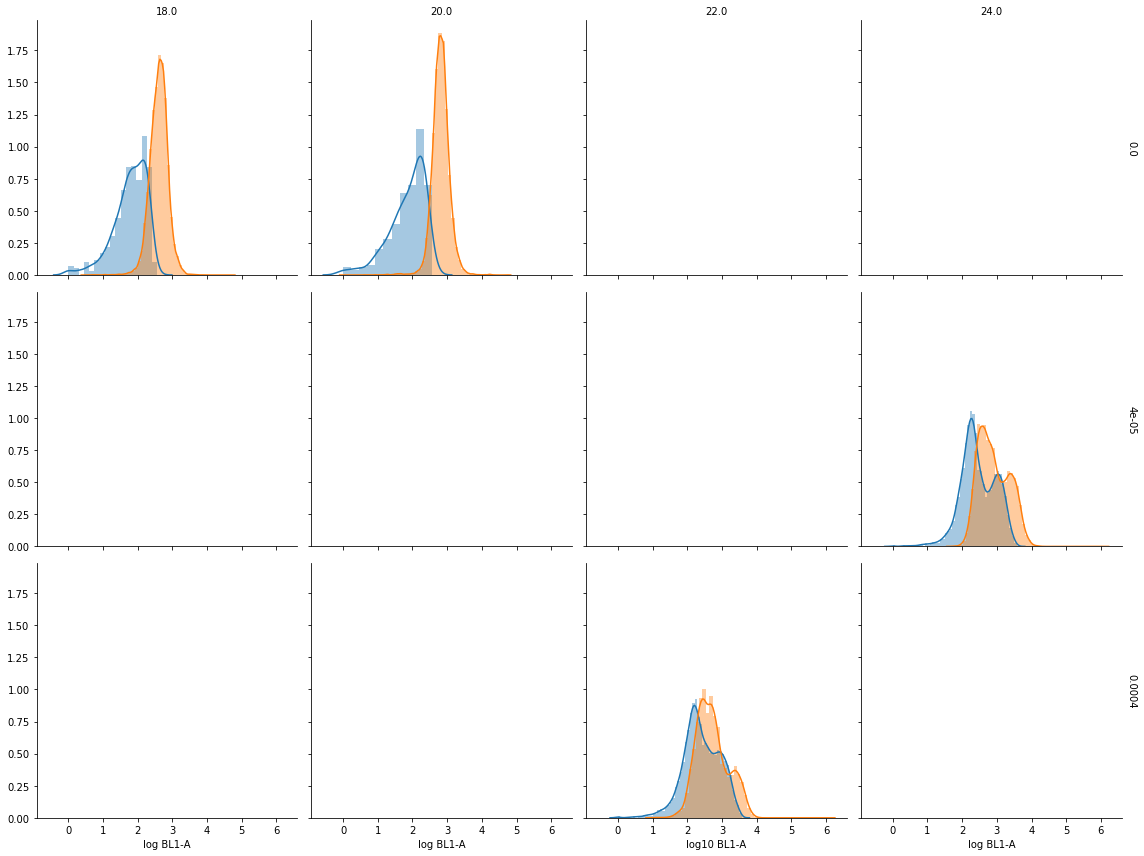

Strain:  CRISPR_CEN.PK2_24952 Replicate:  9


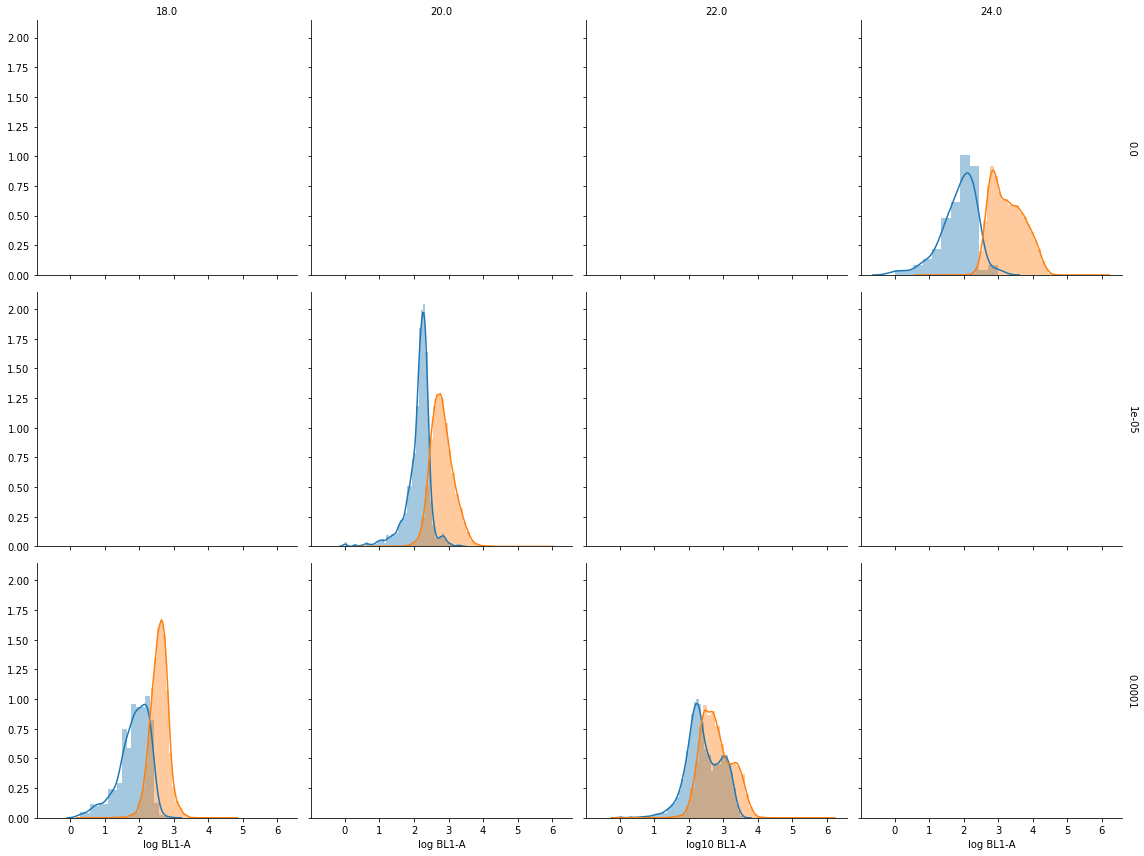

Strain:  CRISPR_CEN.PK2_24952 Replicate:  10


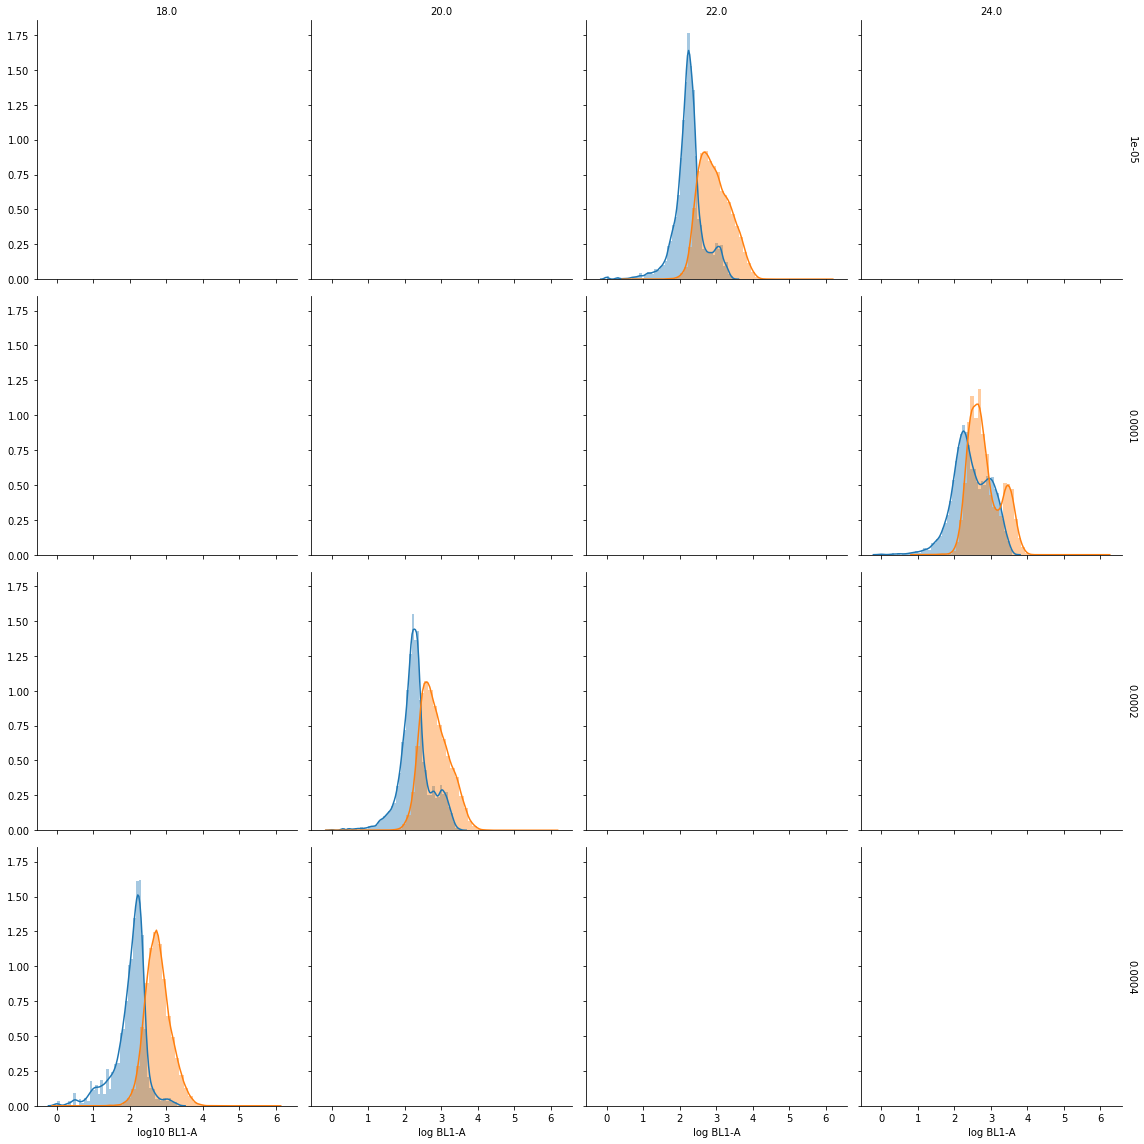

Strain:  CRISPR_CEN.PK2_24952 Replicate:  11


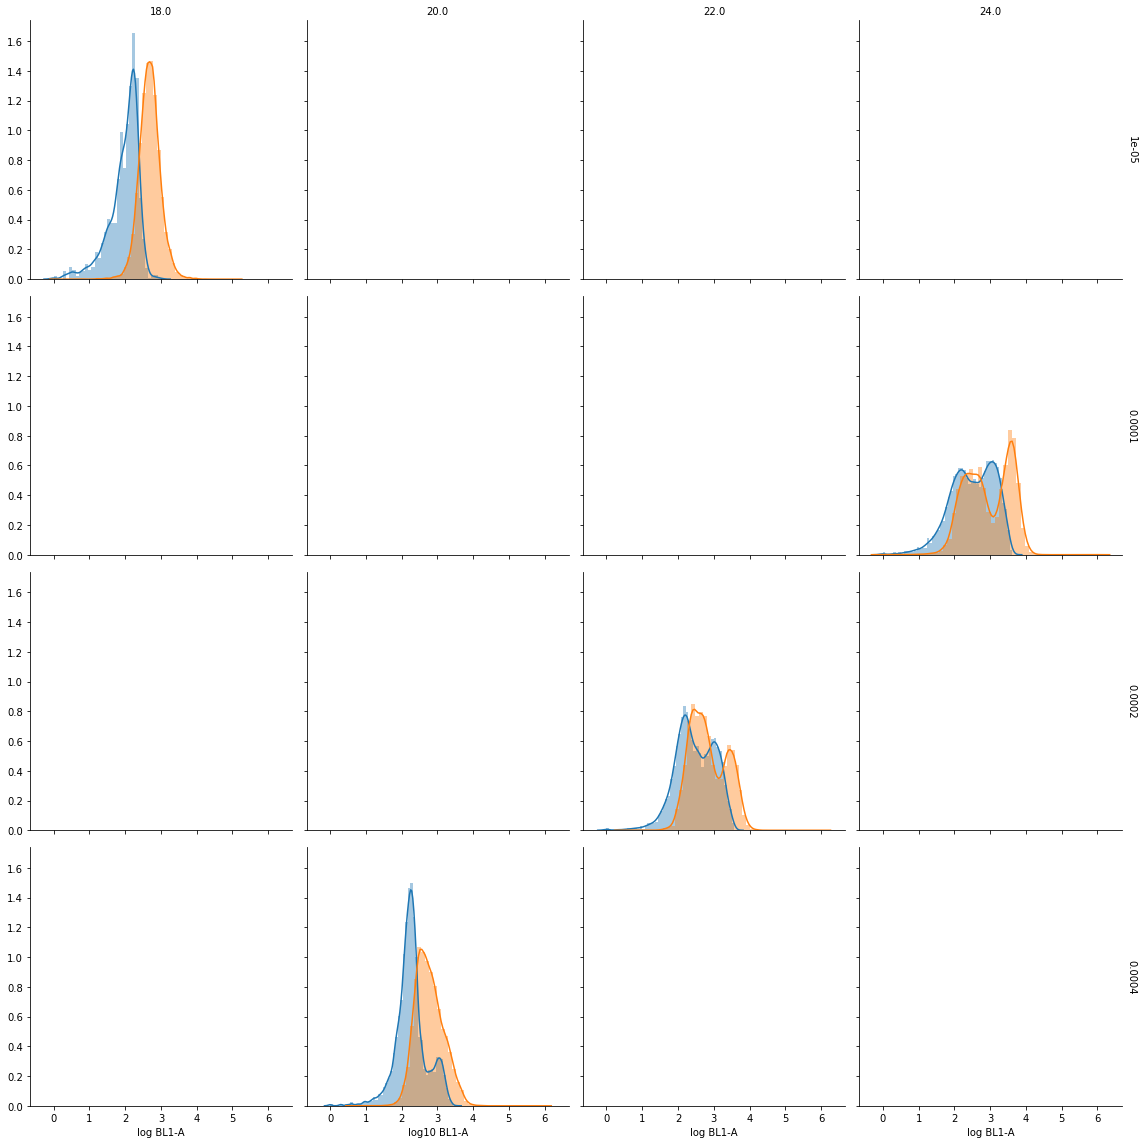

Strain:  CRISPR_CEN.PK2_24952 Replicate:  12


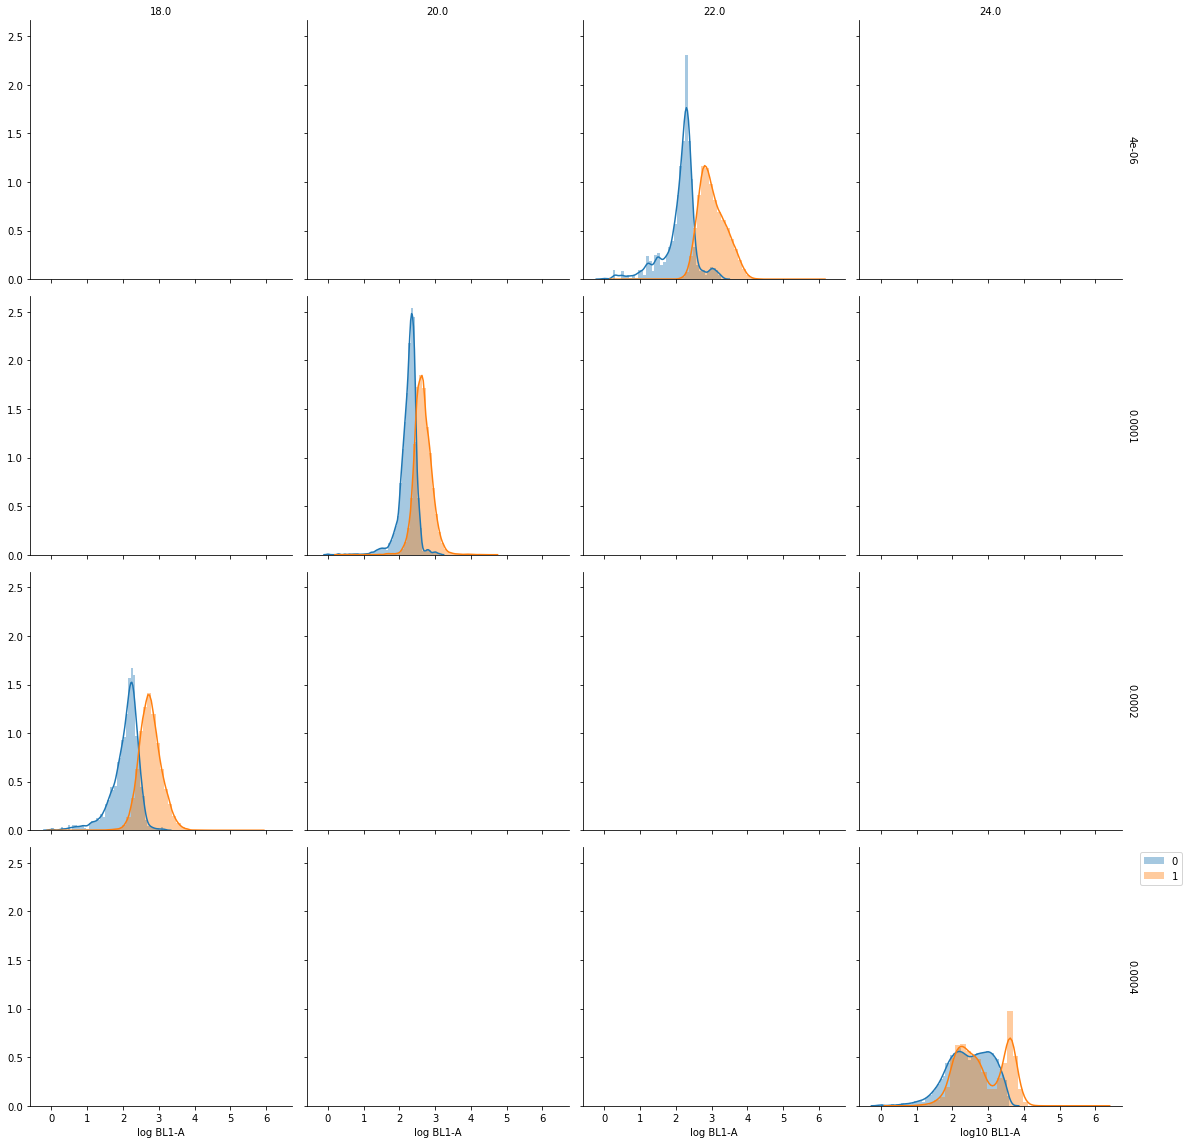

In [74]:
## Analyze performance of a single strain

strain = strains[1]
my_data = ddf.loc[ddf.strain_name == strain]
replicates = my_data.replicate.unique()
replicates.sort()

for replicate in replicates:
    print("Strain: ", strain, "Replicate: ", replicate)
    my_data_rep = my_data.loc[my_data.replicate == replicate]
    g = sns.FacetGrid(my_data_rep, col="timepoint", row='inducer_concentration', hue="predicted_output", height=4, margin_titles=True)
    g.map(sns.distplot, 'log BL1-A')
    [plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                # important to add this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')       



    #my_data = ddf.loc[ddf.strain_name == strain]
    #my_data0 = my_data.loc[my_data.predicted_output == 0]['log BL1-A']
    #my_data1 = my_data.loc[my_data.predicted_output == 1]['log BL1-A']
    #sns.distplot(my_data0, label=strain+"_0", hist=False) 
    #sns.distplot(my_data1, label=strain+"_1", hist=False) 
    #plt.title("YeastSTATES-CRISPR-Long-Duration-Time-Series")
    plt.xlabel("log10 BL1-A")
    plt.legend(bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')       
    plt.show()



Strain:  CRISPR_CEN.PK2_24952 Replicate:  1


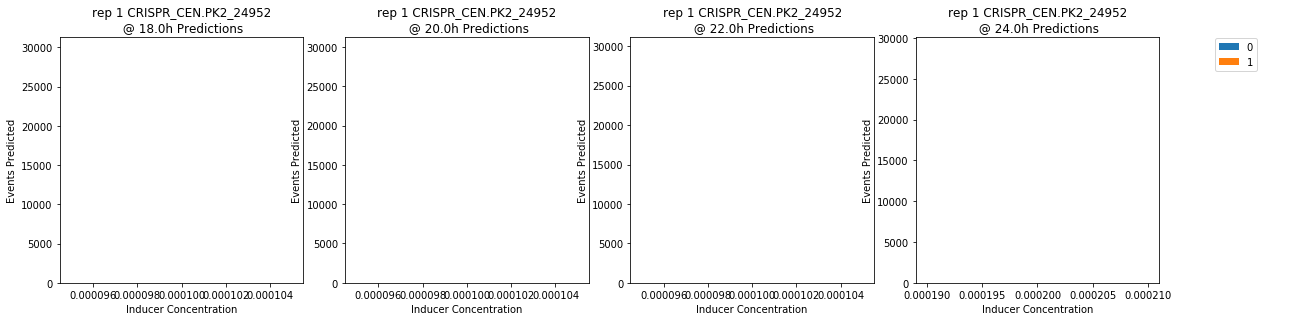

Strain:  CRISPR_CEN.PK2_24952 Replicate:  2


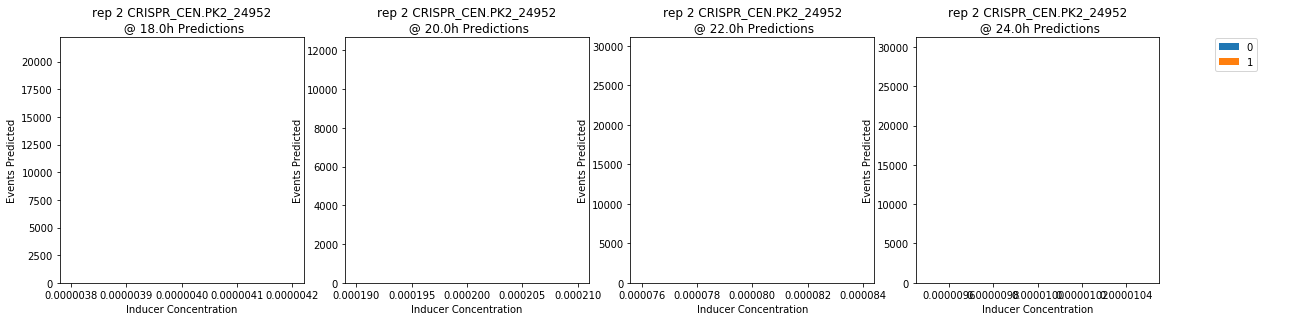

Strain:  CRISPR_CEN.PK2_24952 Replicate:  3


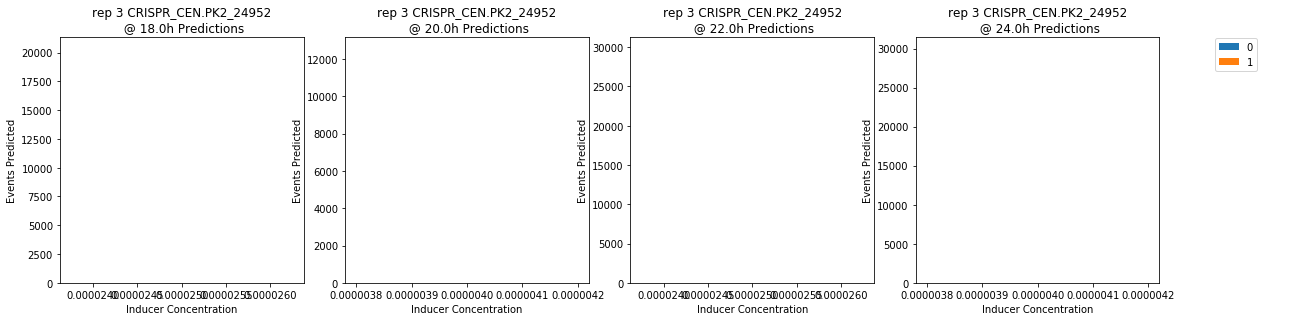

Strain:  CRISPR_CEN.PK2_24952 Replicate:  4


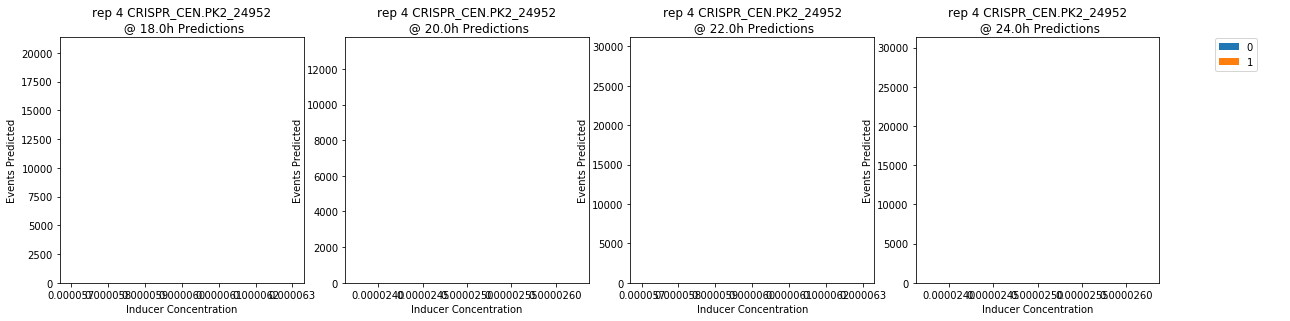

Strain:  CRISPR_CEN.PK2_24952 Replicate:  5


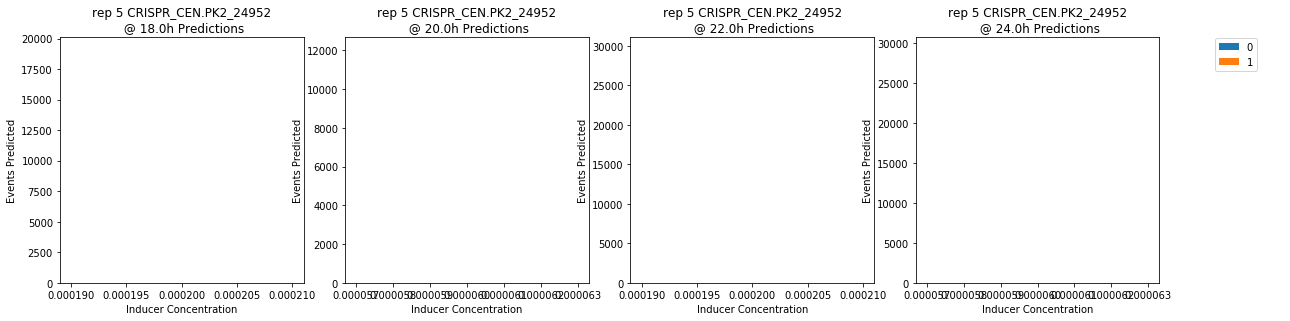

Strain:  CRISPR_CEN.PK2_24952 Replicate:  6


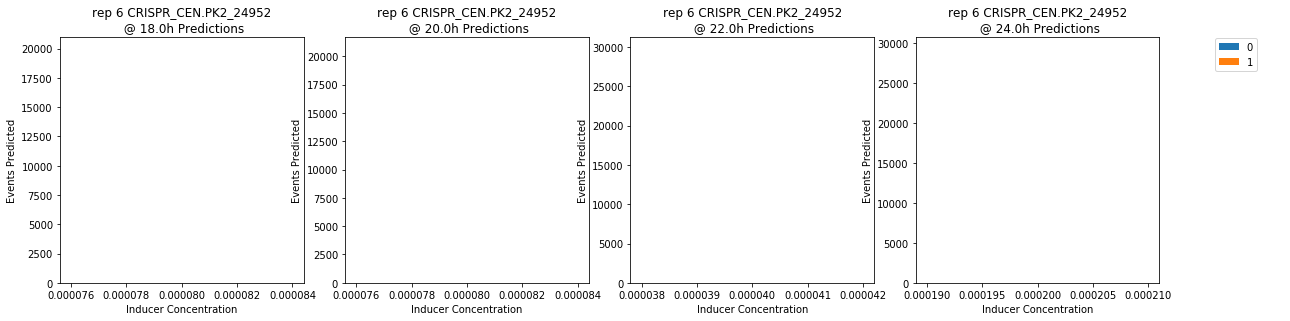

Strain:  CRISPR_CEN.PK2_24952 Replicate:  7


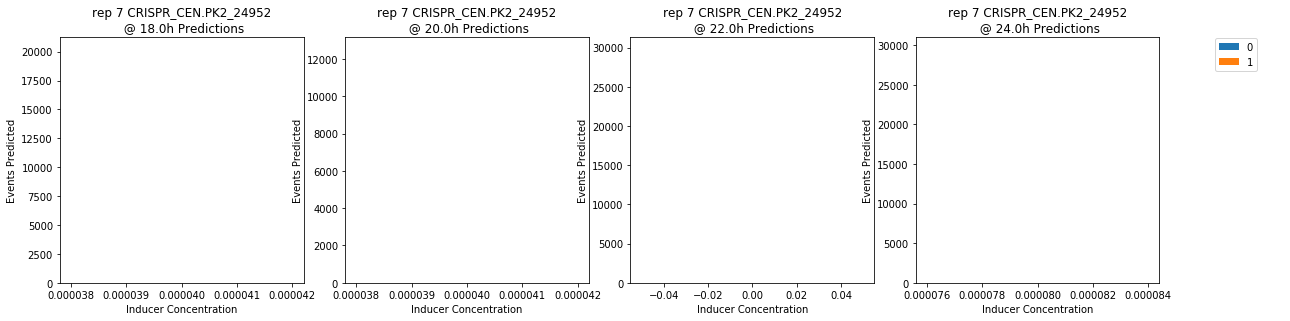

Strain:  CRISPR_CEN.PK2_24952 Replicate:  8


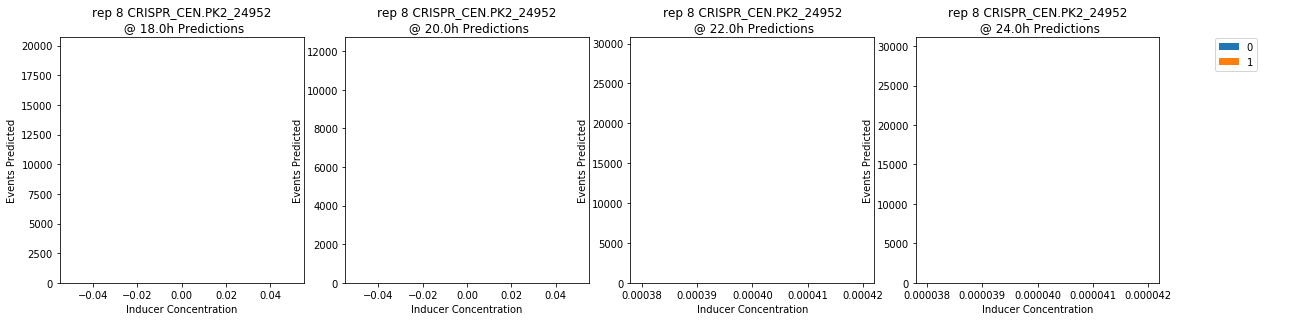

Strain:  CRISPR_CEN.PK2_24952 Replicate:  9


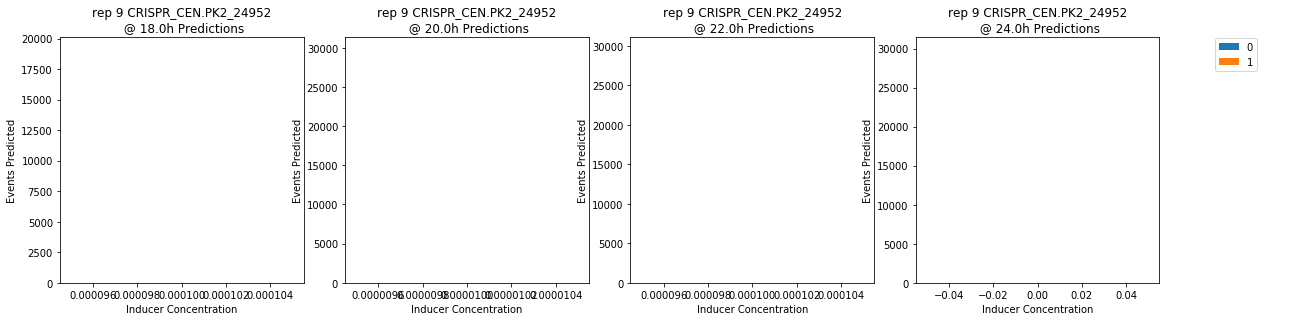

Strain:  CRISPR_CEN.PK2_24952 Replicate:  10


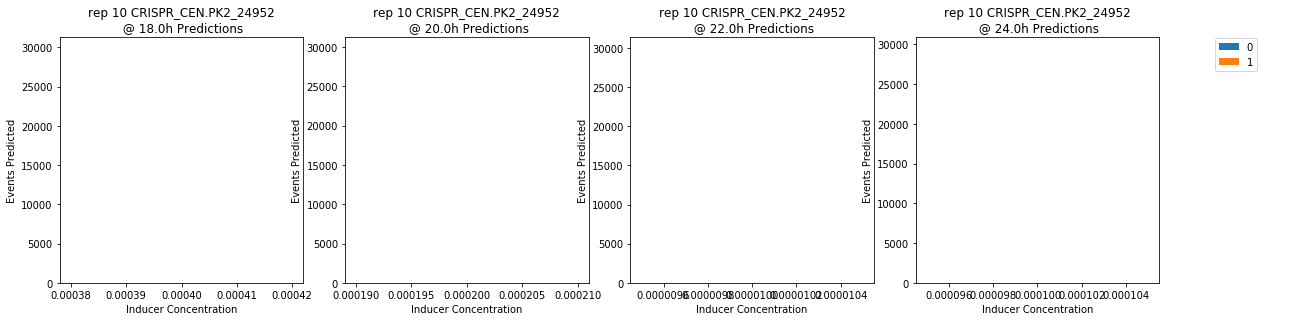

Strain:  CRISPR_CEN.PK2_24952 Replicate:  11


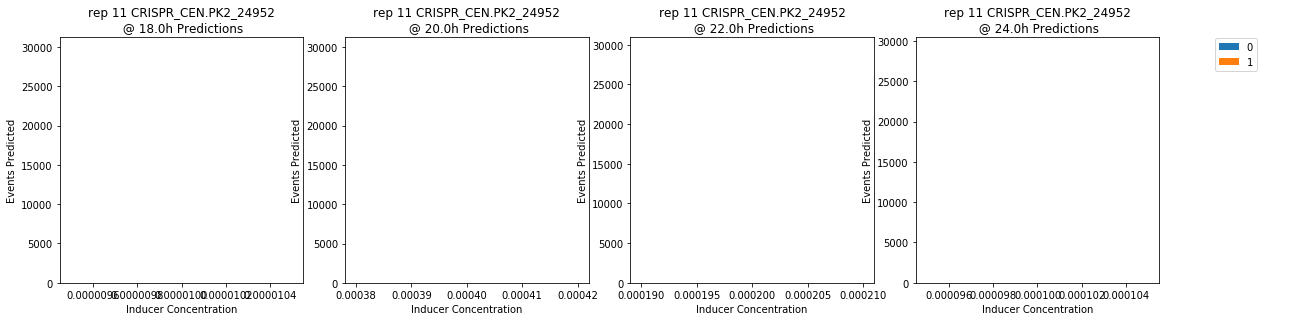

Strain:  CRISPR_CEN.PK2_24952 Replicate:  12


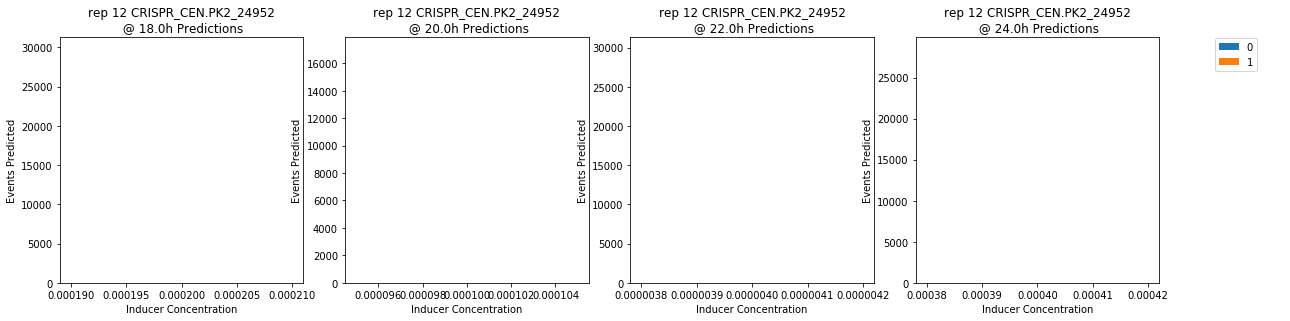

In [75]:
def pad_inducer_output(group_agg_rep, timepoint, replicate):
    inducer_concs = group_agg_rep.inducer_concentration.unique()
    for i in inducer_concs:
        gari = group_agg_rep.loc[group_agg_rep.inducer_concentration == i]
        garip = gari.predicted_output.unique()
        for j in [0, 1]:
            if j not in garip:
                group_agg_rep = group_agg_rep.append({"inducer_concentration" : i, 
                                      "predicted_output" : j,
                                     "replicate" : replicate,
                                     "timepoint" : timepoint,
                                     "log BL1-A" : None}, ignore_index=True)
    return group_agg_rep
    
prediction_groups = my_data.groupby(['inducer_concentration', 'predicted_output', 'replicate', 'timepoint'])
group_agg = prediction_groups.agg(len)['log BL1-A'].reset_index()
mean_agg = prediction_groups.agg(np.mean)['log BL1-A'].reset_index()

for replicate in replicates:
    print("Strain: ", strain, "Replicate: ", replicate)

    fig, axes = plt.subplots(1, len(timepoints), figsize=(16,4))
    fig.tight_layout()
    handles=None
    for i, timepoint in enumerate(timepoints):
        group_agg_rep = group_agg[(group_agg.replicate == replicate) & (group_agg.timepoint == timepoint)]
        
        ## add nan for inducer concentrations that only predict one output
        group_agg_rep = pad_inducer_output(group_agg_rep, timepoint, replicate)
        
        if len(group_agg_rep) == 0:
            continue
        
        ind_conc = group_agg_rep.loc[group_agg_rep.predicted_output==0]['inducer_concentration']
        low_count = group_agg_rep.loc[group_agg_rep.predicted_output==0]['log BL1-A']
        high_count = group_agg_rep.loc[group_agg_rep.predicted_output==1]['log BL1-A']
        
        if not handles:
            handles = [0, 1]
            
        #print(group_agg_rep)
#        print(ind_conc)
#        print(low_count)
#        print(high_count)
        axes[i].stackplot(ind_conc,  low_count, high_count, labels=[0, 1])
    #plt.xscale('log')
#        axes[i].legend(bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
        axes[i].set_title("rep {} {}\n @ {}h Predictions".format(replicate, strain, timepoint))
        axes[i].set_xlabel("Inducer Concentration")
        axes[i].set_ylabel("Events Predicted")
    fig.legend(handles, bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')
    plt.show()

Strain:  CEN.PK2_ATAF1_gfp_34283 Replicate:  1


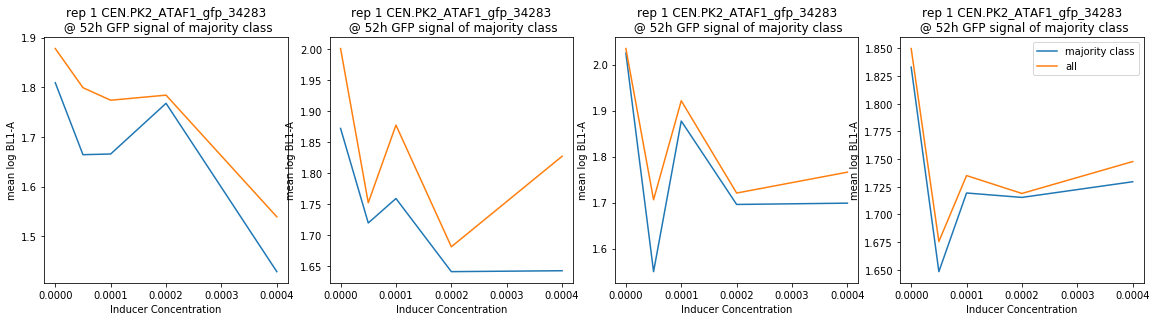

Strain:  CEN.PK2_ATAF1_gfp_34283 Replicate:  2


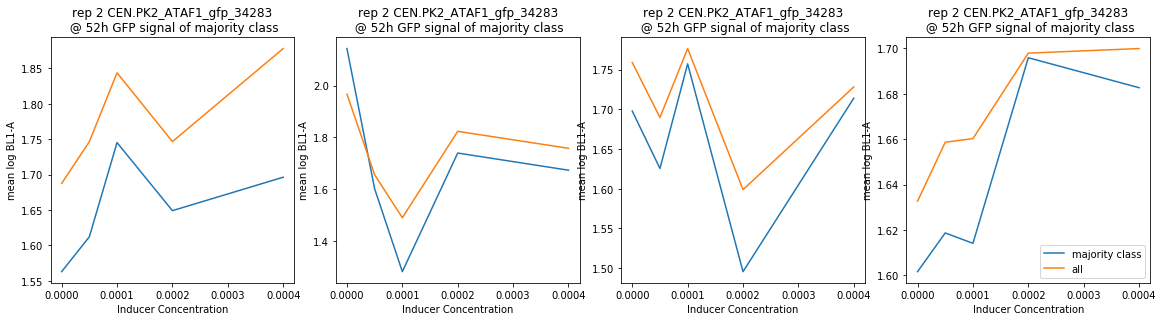

In [69]:
## Get the GFP of the majority class

prediction_groups = my_data.groupby(['inducer_concentration', 'predicted_output', 'replicate', 'timepoint'])
all_groups = my_data.groupby(['inducer_concentration', 'replicate', 'timepoint'])
group_agg = prediction_groups.agg(len)['log BL1-A'].reset_index().rename(columns={"log BL1-A" : "count"})
mean_agg = prediction_groups.agg(np.mean)['log BL1-A'].reset_index().rename(columns={"log BL1-A" : "mean log BL1-A"})
all_mean_agg = all_groups.agg(np.mean)['log BL1-A'].reset_index().rename(columns={"log BL1-A" : "mean log BL1-A"})
mean_agg = mean_agg.merge(group_agg)
max_agg = mean_agg.sort_values('count', ascending=False).drop_duplicates(['inducer_concentration', 'replicate', 'timepoint']).sort_values('inducer_concentration')

#groupby('inducer_concentration')['count'].transform(max) == mean_agg['count']
#print(max_agg)
#mean_agg = prediction_groups.agg(np.mean)['log BL1-A'].reset_index()

for replicate in replicates:
    print("Strain: ", strain, "Replicate: ", replicate)

    fig, axes = plt.subplots(1, len(timepoints), figsize=(16,4))
    fig.tight_layout()
    handles=None
    for i, timepoint in enumerate(timepoints):
        max_agg_rep = max_agg.loc[(max_agg.replicate==replicate) &  (max_agg.timepoint == timepoint)]
        all_mean_agg_rep = all_mean_agg.loc[(all_mean_agg.replicate==replicate) & (all_mean_agg.timepoint == timepoint)]


        #for out in mean_agg.predicted_output.unique():
        #    dat = mean_agg.loc[mean_agg.predicted_output == out]
        axes[i].plot(max_agg_rep.inducer_concentration, max_agg_rep['mean log BL1-A'], label='majority class')
        axes[i].plot(all_mean_agg_rep.inducer_concentration, all_mean_agg_rep['mean log BL1-A'], label='all')
        #plt.xscale('log')
        axes[i].set_title("rep {} {}\n @ {}h GFP signal of majority class".format(replicate, strain, time))
        axes[i].set_xlabel("Inducer Concentration")
        axes[i].set_ylabel('mean log BL1-A')
    plt.legend()
    plt.show()
    

In [52]:
my_data.groupby(['inducer_concentration']).agg(np.mean)['predicted_output'].apply(lambda x: 1-x)

inducer_concentration
0.000000    0.238345
0.000004    0.258238
0.000010    0.328045
0.000025    0.523360
0.000040    0.602540
0.000060    0.648287
0.000080    0.641315
0.000100    0.727740
0.000200    0.805428
0.000400    0.806696
Name: predicted_output, dtype: float64

In [7]:
#df[['strain', 'strain_name']].drop_duplicates()
df.columns

Index(['Unnamed: 0', 'TX_plate_name', 'TX_project_name', 'TX_sample_name', '_id', 'date_of_experiment', 'experiment_id', 'experiment_reference', 'flow_rate_uL/min', 'flow_volume', 'inducer_concentration', 'inducer_concentration_unit', 'inducer_type', 'lab', 'media_type', 'replicate', 'sample_id', 'strain', 'strain_name', 'temperature', 'temperature_unit', 'timepoint', 'timepoint_unit', 'total_counts', 'well_id', 'FSC-A', 'SSC-A', 'BL1-A', 'FSC-W', 'FSC-H', 'SSC-W', 'SSC-H', 'output', 'index', 'predicted_output', 'predicted_correct', 'predicted_high', 'predicted_low', 'log BL1-A'], dtype='object')

In [8]:
df.output.unique()

array([1])

In [2]:

def do_plot(res_meta, out_file="plot.png"):
    t=res_meta.groupby(['strain_name', 'inducer_concentration', 'timepoint']).agg(np.mean).reset_index()#.sort_values(by=["mean_correct_classifier"])
    #sns.distplot(t)
    plot_strains = [x for x in t.strain_name.unique() if "ducible" in x]
    t = t.loc[t.strain_name.str.contains("ducible")]

    
    #f, ax = plt.subplots()
    #ax.set_xscale("log")
    #ax.set_xlim(10e-6, 10e-4)
    #ax.set_ylim(0, 1)
    if 'timepoint' in t.columns:
        g = sns.FacetGrid(t, col="timepoint", hue="strain_name", height=10, margin_titles=True)
        g.map(sns.lineplot, 'inducer_concentration', "mean_correct_low_classifier")
        [plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')       
    else:
        g= sns.lineplot(dat.inducer_concentration, dat.mean_correct_low_classifier, ax=ax, label=strain)
        
    g.set(xscale="log")
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)    
    g.savefig(out_file)

    plt.close()

In [3]:
for experiment_analysis in correctness_dir_contents:

    data_converge_id = du.get_data_converge_id(experiment_analysis)
    csv_file = os.path.join(correctness_dir, data_converge_id + ".csv")
    if os.path.exists(csv_file):
        res = pd.read_csv(csv_file)
        data_converge_path = os.path.join(data_converge_base, 'test', data_converge_id)
        res_meta = du.get_meta(data_converge_path, 
                               du.get_record(data_converge_path)).merge(res, on="sample_id", how="inner")

        out_file_path = os.path.join(expanduser("~"), "tacc-work", "plots")
        if not os.path.exists(out_file_path):
            os.mkdir(out_file_path)
        out_file = os.path.join(out_file_path, data_converge_id + ".png")
        do_plot(res_meta, out_file)
        

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200414085017.png


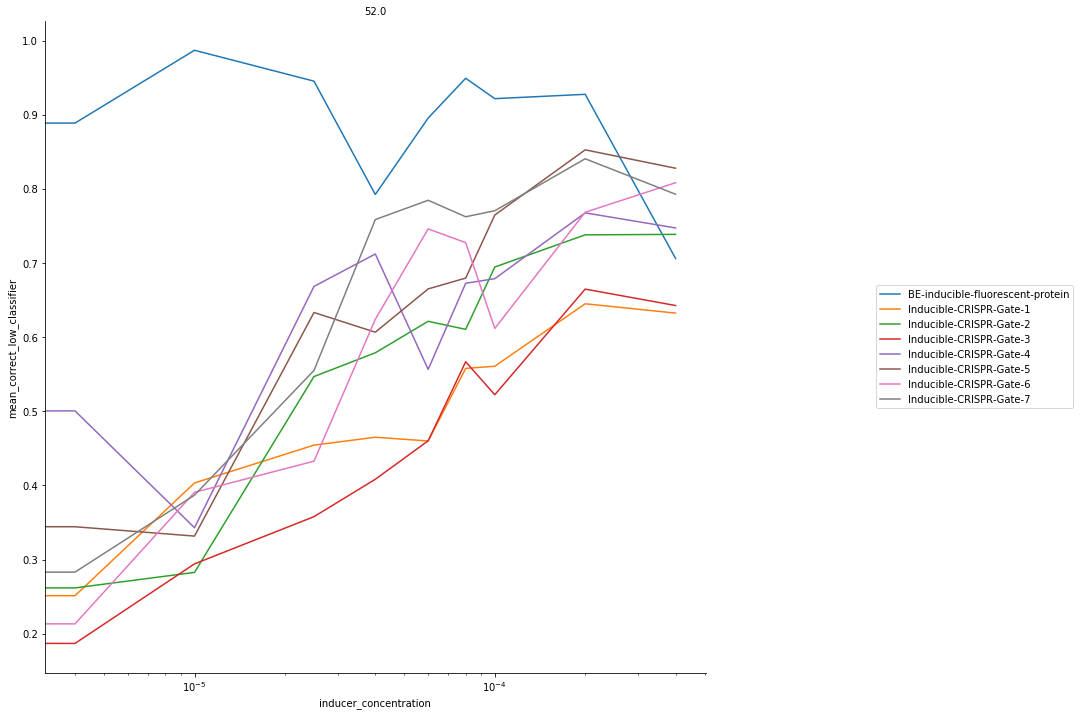

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Dose-Response_20200327165322.png


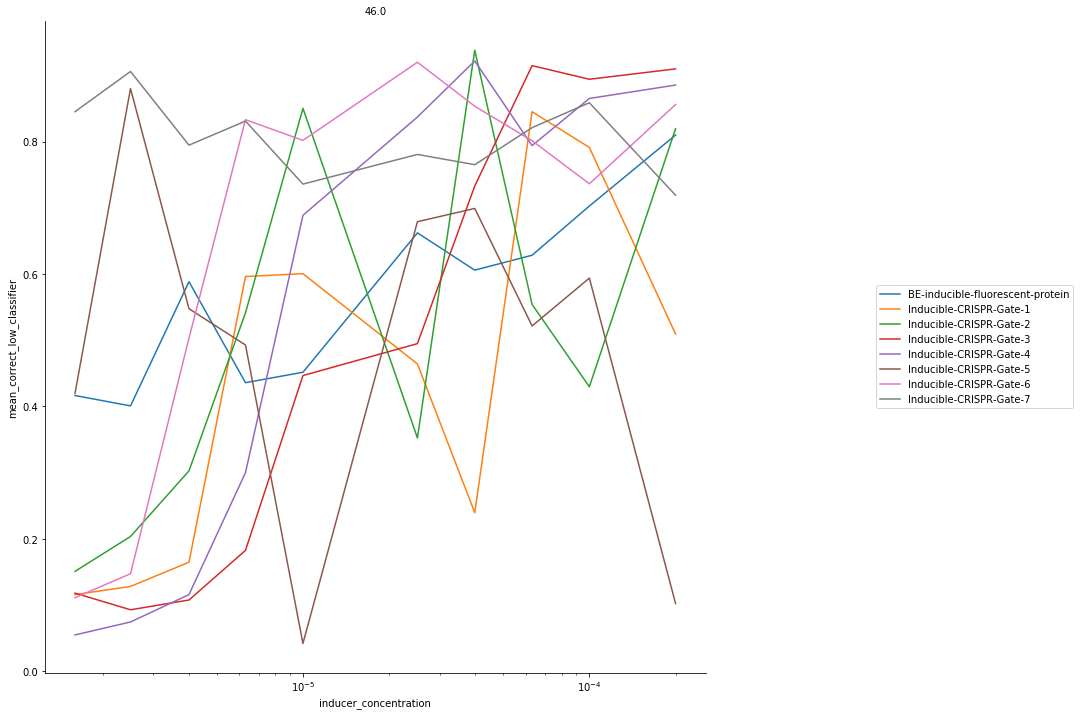

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Long-Duration-Time-Series-20191208_20200328071458.png


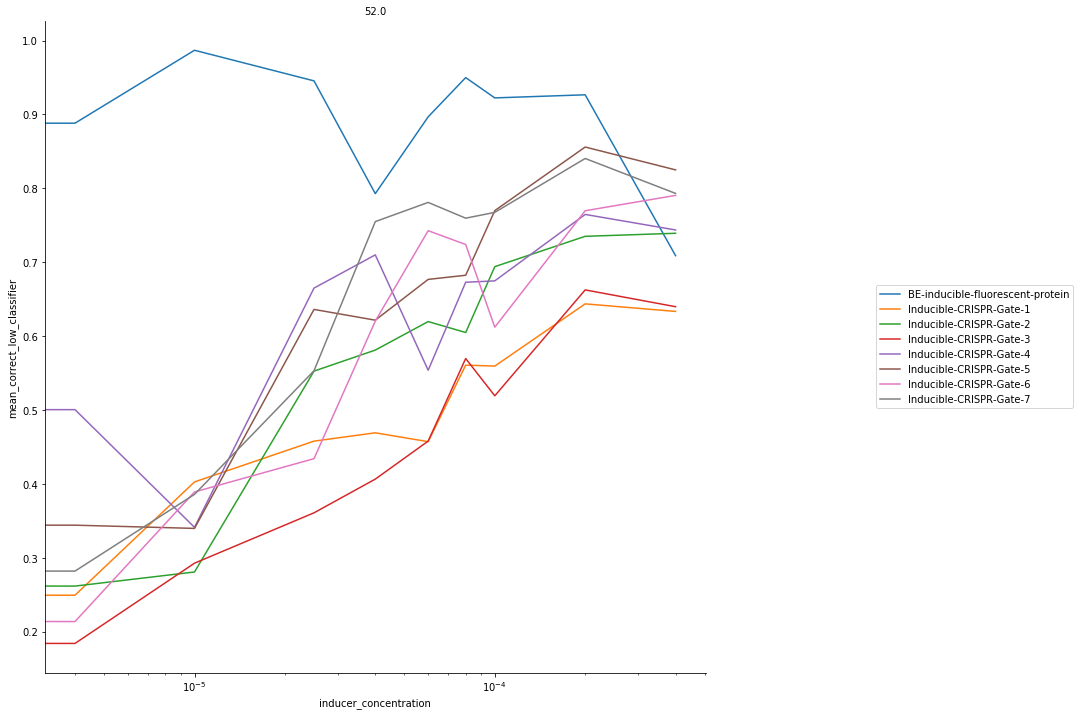

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200414095504.png


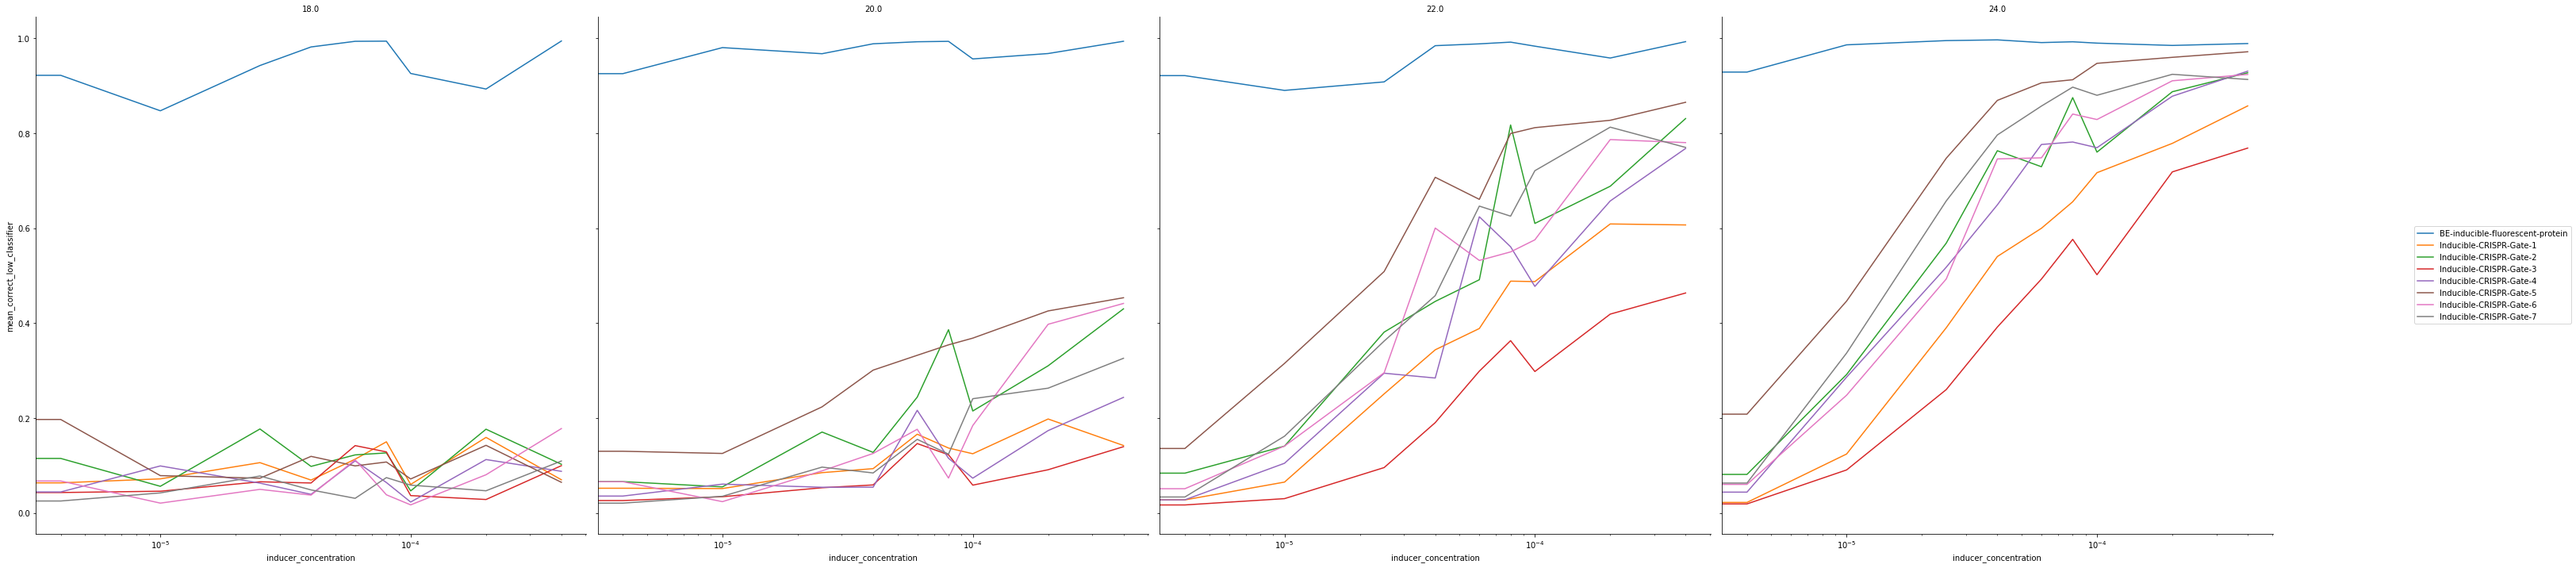

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200328030858.png


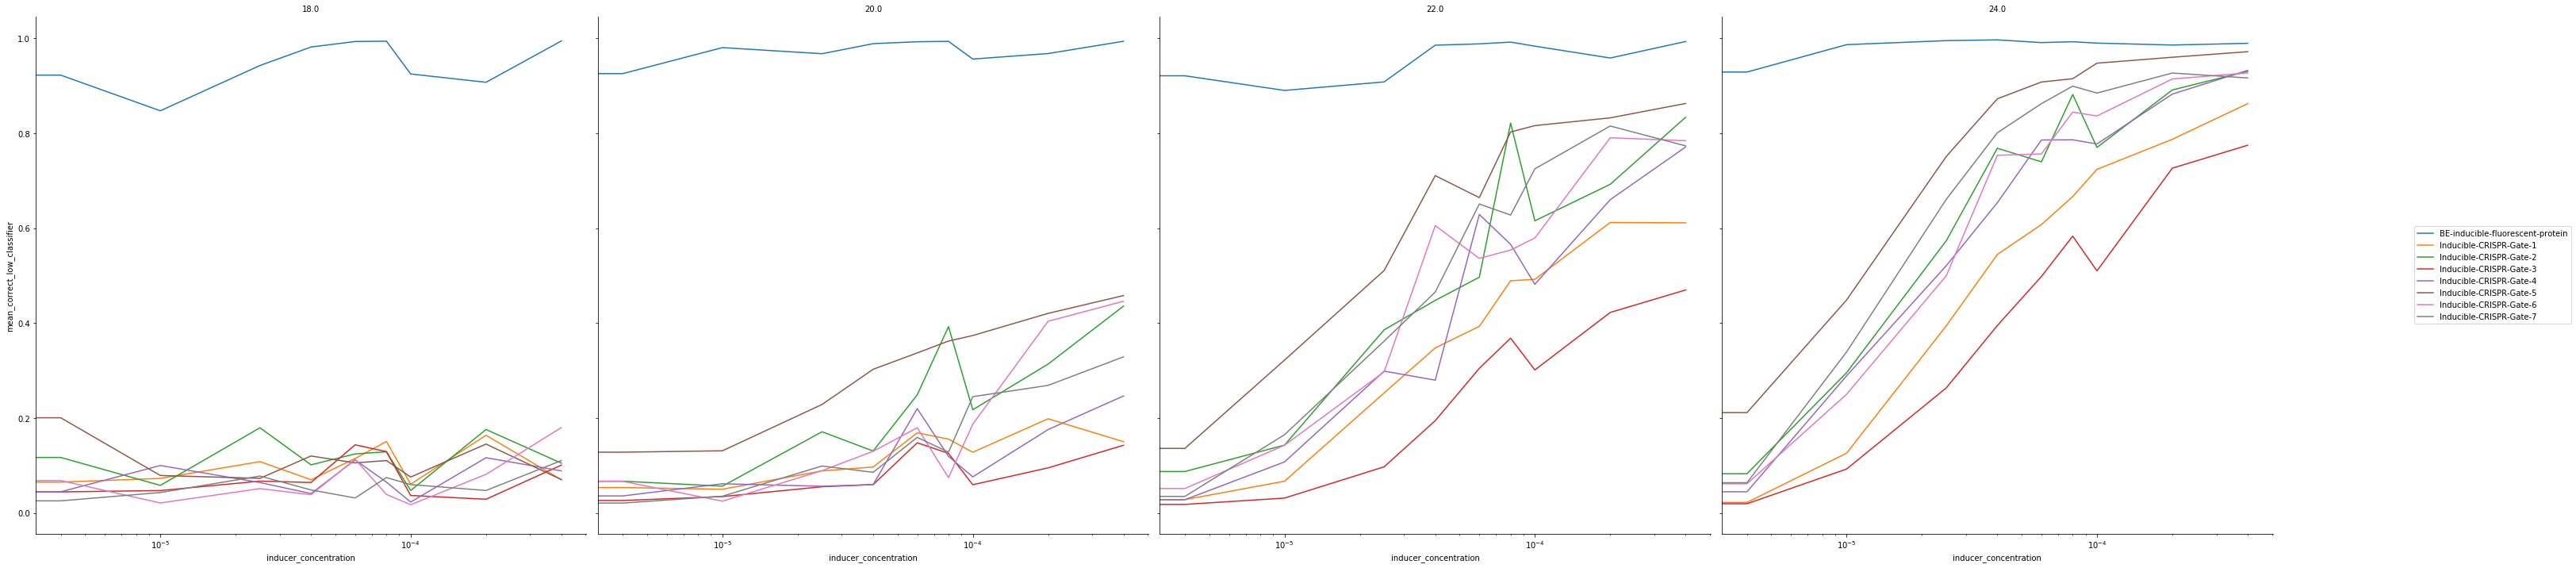

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Dose-Response_20200414151033.png


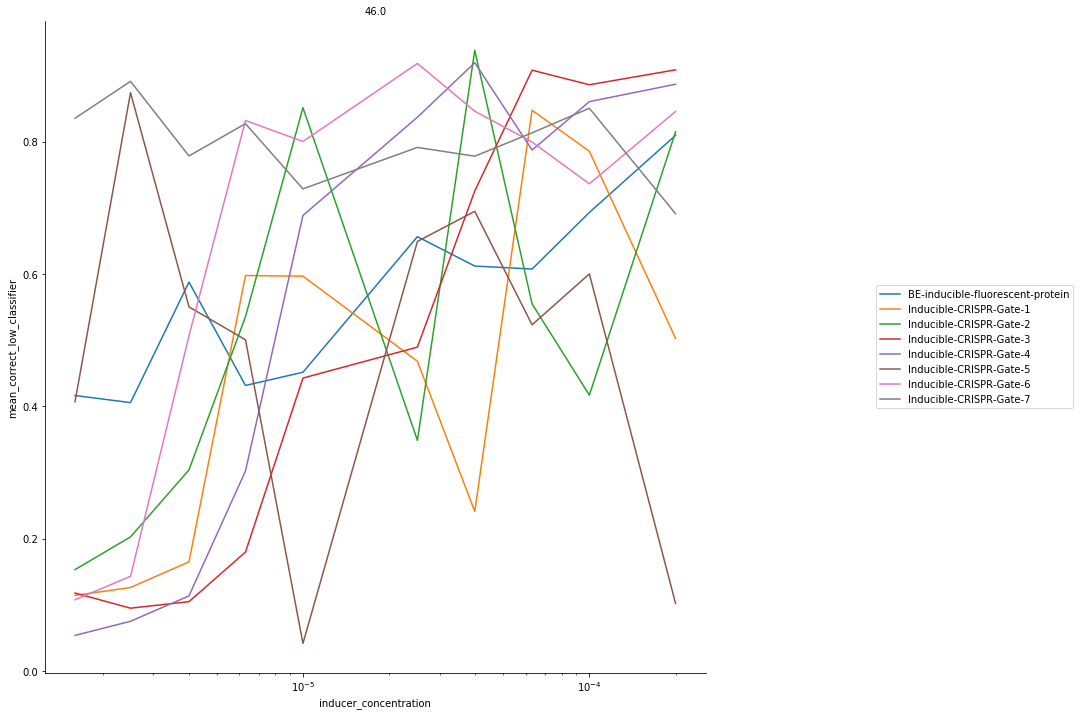

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200414152048.png


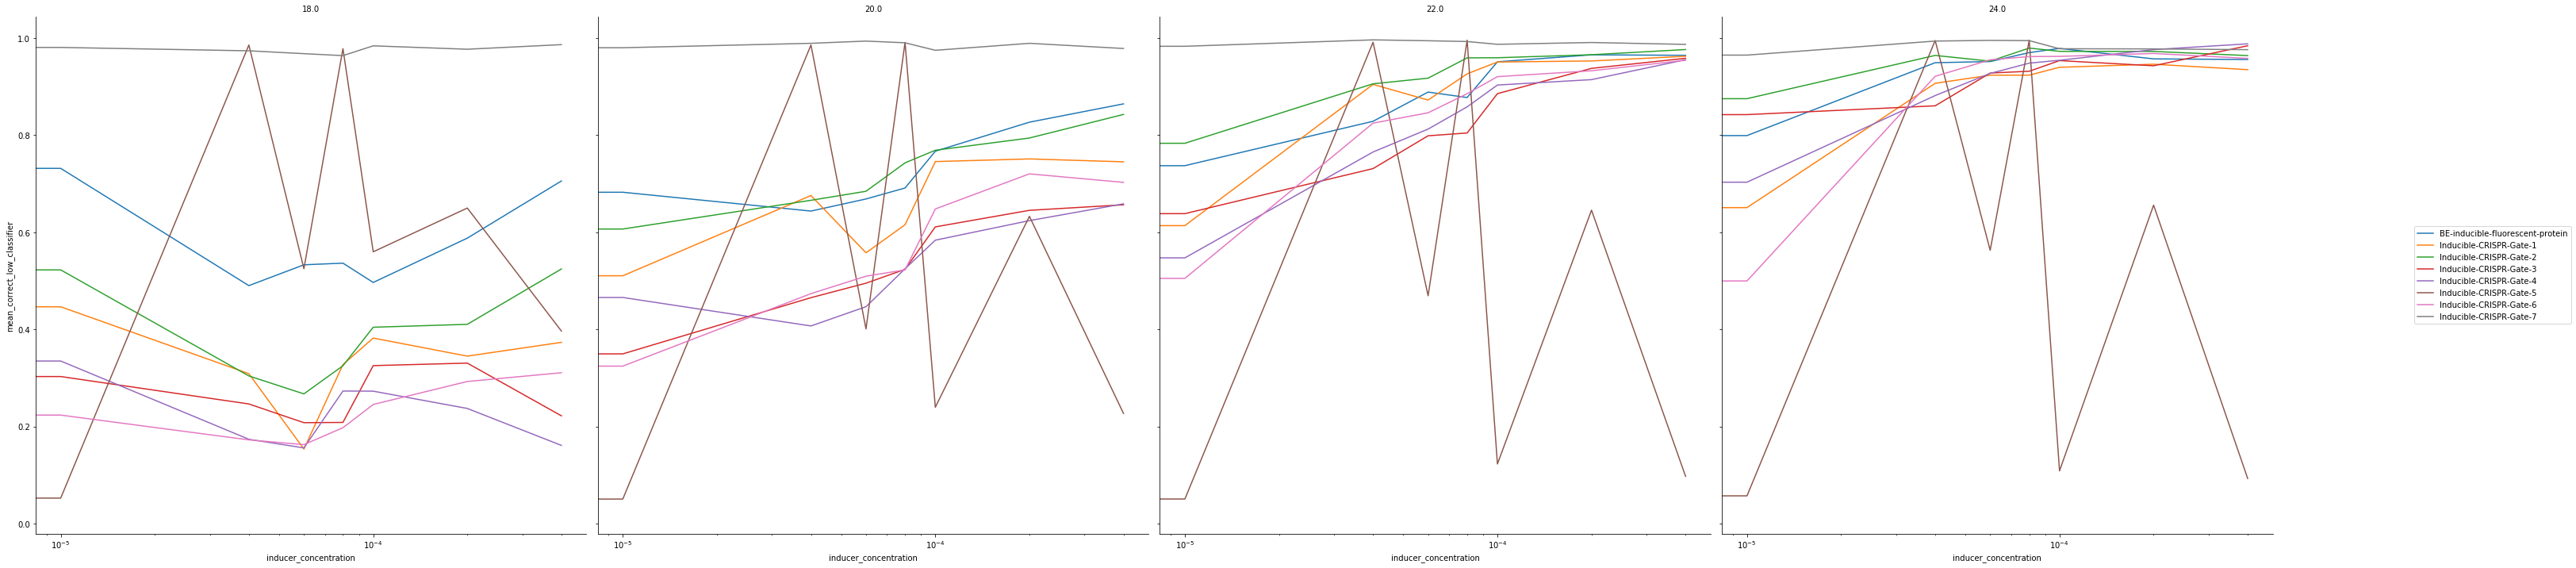

/work/05202/dbryce/jupyter/tacc-work/plots/dc_YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response_20200414091814.png


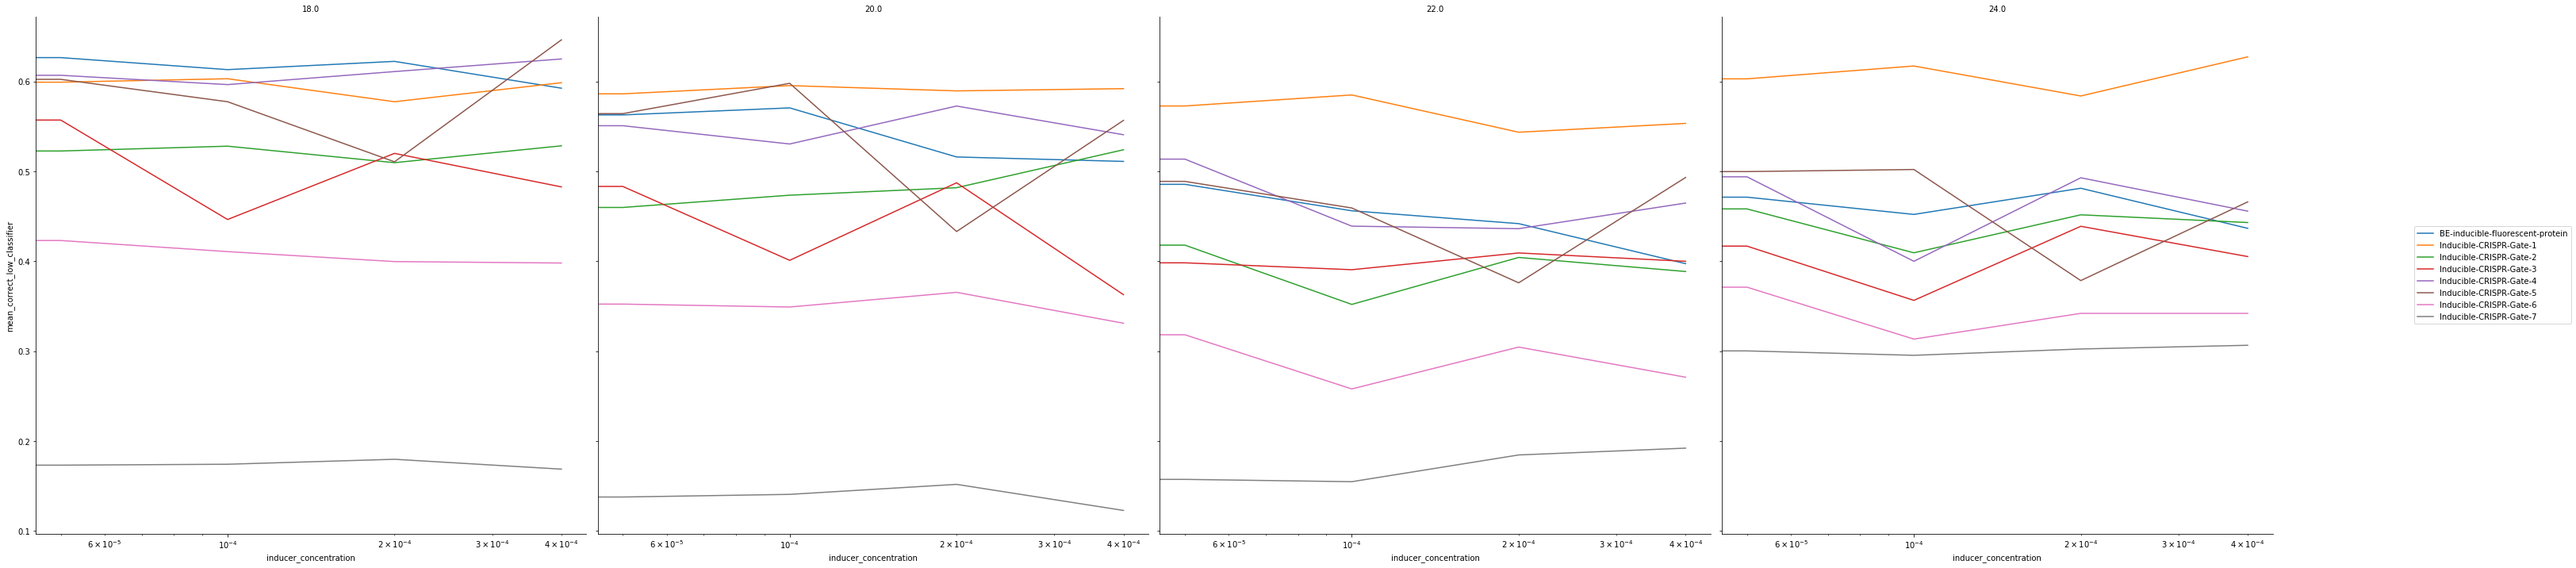

In [5]:
from IPython.display import display, Image
for experiment_analysis in correctness_dir_contents:
    data_converge_id = du.get_data_converge_id(experiment_analysis)
    out_file_path = os.path.join(expanduser("~"), "tacc-work", "plots")
    out_file = os.path.join(out_file_path, data_converge_id + ".png")
    print(out_file)
    display(Image('{}'.format(out_file)))
